In [1]:
%pip install gdown
%pip install mahotas
import gdown

url = "https://drive.google.com/drive/folders/1ZKMUq6U6pRw7zcP6AkGxoQVX3LnMnGXC?usp=share_link"
gdown.download_folder(url, quiet=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 33.0 MB/s eta 0:00:00


['/content/splitted_dataset/dlib_face_recognition_resnet_model_v1.dat',
 '/content/splitted_dataset/eyes.zip',
 '/content/splitted_dataset/mouth.zip',
 '/content/splitted_dataset/nose.zip']

**IMPORT THE NECESSARY LIBRARIES FOR THE NOTEBOOK TO WORK**

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import zipfile
import shutil
from collections import defaultdict
from PIL import Image
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from torch.utils.data import  Dataset

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:

# Datapath Project_Biometric/Dataset
folder_path = "splitted_dataset"
for file_name in os.listdir(folder_path):

    # zipped files in the folder biometric_systems_dataset
    if file_name.endswith(".zip"):

      # full path to the zip file
      file_path = os.path.join(folder_path, file_name)

      # create folder in the same path with the name of the zip file
      extract_folder = os.path.join(folder_path, file_name.replace(".zip", ""))
      os.makedirs(extract_folder, exist_ok=True)

      # open and extract the file
      with zipfile.ZipFile(file_path, mode="r") as zip_ref:
        zip_ref.extractall(extract_folder)
      os.remove(file_path)

for folder in os.listdir(folder_path):
    dir_path = os.path.join(folder_path, folder)

    # Procedi solo se è una directory
    if os.path.isdir(folder_path):
        train_folder = os.path.join(dir_path, "train")
        test_folder = os.path.join(dir_path, "test")

        train_count = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]) if os.path.exists(train_folder) else 0
        test_count = len([f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]) if os.path.exists(test_folder) else 0

        print(f"Cartella '{folder}':")
        print(f"  Train set: {train_count} file")
        print(f"  Test set: {test_count} file")

Cartella 'eyes':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'dlib_face_recognition_resnet_model_v1.dat':
  Train set: 0 file
  Test set: 0 file
Cartella 'nose':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'mouth':
  Train set: 18255 file
  Test set: 4776 file


**Checking the availability of the images**

In [10]:
# def display_first_image(folder_path):
#     image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

#     if not image_files:
#         print("No images found in the specified folder.")
#         return

#     first_image_path = os.path.join(folder_path, image_files[0])

#     try:
#         img = Image.open(first_image_path)
#         plt.imshow(img)
#         plt.show()
#     except IOError:
#         print("Error opening image file:", first_image_path)

# # Replace with your actual folder path
# #folder_path = "/content/splitted_dataset/eyes/train"
# folder_path = "/content/splitted_dataset/mouth/train"
# #folder_path = "/content/splitted_dataset/nose/train"
# display_first_image(folder_path)

**Getting the frequencies of the labels**

In [12]:
# #datapath="/content/splitted_dataset/eyes/train"
# #datapath="/content/splitted_dataset/eyes/test"
# datapath="/content/splitted_dataset/mouth/train"#
# class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
# total_images = 0

# for filename in os.listdir(datapath):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         total_images += 1
#         parts = filename.split('_')
#         if len(parts) >= 4:
#             label = int(parts[3])  # Convert label to integer
#             class_counts[label] += 1

# print("Total images:", total_images)
# print("Class counts:", class_counts)

**COMPUTING THE HISTOGRAMS FOR THE LBP**

In [13]:
def calculate_lbp(image, R=1, P=8):
    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply LBP operator
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    #lbp = cv2.LBP(gray, neighbors, radius)

    # Calculate histogram
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(257))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= hist.sum() + 1e-7

    return hist

**CREATING THE DATASET**

In [27]:
# Dataset personalizzato
class EthnicityDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.labels = []
        self.features=[]


        # Scansione della cartella per ottenere i file
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Considerando immagini .jpg e .png
                self.images.append(filename)

                # Estraiamo l'etnia dalla parte finale del nome del file
                # esempio: eyes_100_1_0_20170112213001988
                parts = filename.split('_')
                if len(parts) >= 4:
                    label = parts[3]  # L'etnia è il quarto elemento (indice 3)
                    label_map = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4}  # Mappatura delle etnie
                    self.labels.append(label_map.get(label, -1))  # -1 se l'etnia non è trovata
        self.labels=np.array(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            return None, None

        label = self.labels[idx]
        # self.labels.append(label)
        # Calculate LBP features
        image = np.array(image)  # Convert to NumPy array for OpenCV
        feature = calculate_lbp(image)
        self.features.append(feature)  # Store features (optional)


        # Aggiungi un controllo se l'etichetta è corretta
        if label == -1:
            print(f"Errore: etichetta non trovata per {image_name}")

        return feature, label

**EXTRACTING THE FEATURES FROM THE DATASET**

In [26]:
def extract_lbp_features(dataset):
    """Extracts LBP features from a list of images.

    Args:
        images: A list of images, where each image is a NumPy array.

    Returns:
        A NumPy array of LBP features.
    """
    # # Get a list of image filenames in the directory
    # image_filenames = os.listdir(root_dir)
    # for filename in image_filenames:
    #   image_path = os.path.join(root_dir, filename)
    #   img = cv2.imread(image_path)
    #   if img is not None:
    #       lbp_features,_ = extract_lbp_features(img)
    # return np.array(lbp_features)
    features = []

    for _ in range(len(dataset)):
      image, label = dataset[_]
      # features.append(image)
      # labels.append(label)
      # features = np.array(features)
      # labels = np.array(labels)
    return np.array(dataset.features)

# # Assuming X_train and X_test are lists of image paths or NumPy arrays
# X_train_lbp = extract_lbp_features(X_train)
# X_test_lbp = extract_lbp_features(X_test)

**EYES TRAINING VALIDATION AND TEST**

In [28]:
#Initialize the dataset
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

full_train_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/eyes/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/eyes/test")

# Extract features for all images in one line
X_train = extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels  # Now contains numerical labels

X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels

In [29]:
def compute_class_weight(class_weight, classes, y, majority_class_weight_factor):
    # """Computes class weights based on class frequency.

    # Args:
    #     class_weight: The class weighting strategy (e.g., 'balanced').
    #     classes: A list of class labels.
    #     y: The true labels of the training data.

    # Returns:
    #     A dictionary mapping class labels to their corresponding weights.
    # """

    # if class_weight == 'balanced':
    #     # Calculate class frequencies
    #     class_counts = np.bincount(y)
    #     print(class_counts)
    #     # Calculate class weights inversely proportional to frequency
    #     class_weights = 1. / class_counts
    #     class_weights = class_weights / class_weights.sum() * len(classes)
    #     print(class_weights)
    #     class_weights = dict(enumerate(class_weights))
    # else:
    #     raise ValueError("Invalid class_weight value")
    # print(class_weights)
    # return class_weights
    if class_weight == 'balanced':
        # Calculate class frequencies
        class_counts = np.bincount(y)

        # Identify the majority class
        majority_class = np.argmax(class_counts)

        # Calculate class weights inversely proportional to frequency
        class_weights = 1. / class_counts

        # Adjust the weight of the majority class
        class_weights[majority_class] *= majority_class_weight_factor

        # Normalize weights
        class_weights = class_weights / (class_weights.sum() * len(classes))

        class_weights = dict(enumerate(class_weights))
    else:
        raise ValueError("Invalid class_weight value")

    return class_weights

<class 'lightgbm.basic.Dataset'>
Training until validation scores don't improve for 15 rounds
[15]	valid_0's multi_logloss: 1.37701
[30]	valid_0's multi_logloss: 1.34294
[45]	valid_0's multi_logloss: 1.32901
[60]	valid_0's multi_logloss: 1.32232
[75]	valid_0's multi_logloss: 1.31823
[90]	valid_0's multi_logloss: 1.31712
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.31566
(4776, 5)
(4776,)
              precision    recall  f1-score   support

           0       0.45      0.93      0.61      2018
           1       0.62      0.19      0.30       927
           2       0.51      0.18      0.26       670
           3       0.48      0.05      0.10       802
           4       0.33      0.01      0.02       359

    accuracy                           0.46      4776
   macro avg       0.48      0.27      0.26      4776
weighted avg       0.49      0.46      0.37      4776



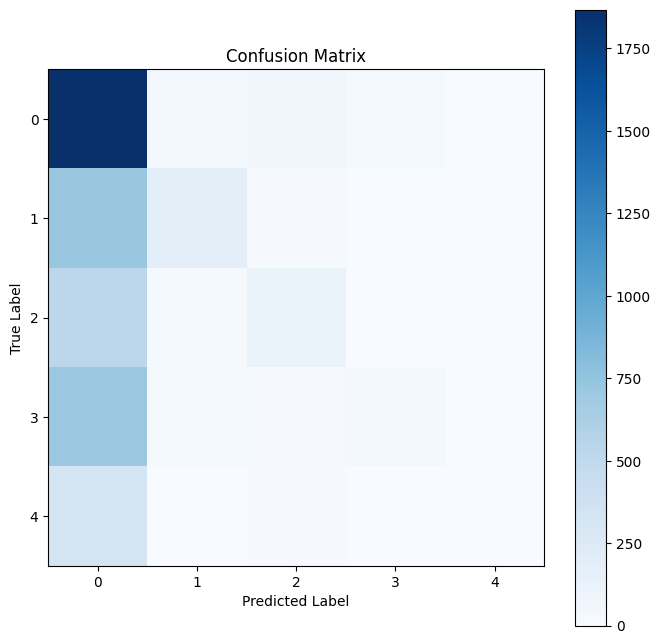

In [30]:
# Calculate class weights
class_weights = compute_class_weight('balanced',  classes=np.unique(y_train), y=y_train, majority_class_weight_factor=4.0)
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), )
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_train])



train_data = lgb.Dataset(X_train, label=y_train,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_train) == 0:
    raise ValueError("X_train cannot be empty")



# Define hyperparameters and objective for LightGBM
params = {
    'objective': 'multiclass',  # Adjust for your specific task
    'num_class': len(np.unique(y_train)),# Number of classes in your dataset
    'metric': 'multi_logloss',
    'learning_rate':  0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'boosting_type': 'gbdt',
    'verbose': -1
    # ... other hyperparameters
}
print(type(train_data))
num_round=100
model = lgb.train(params,
                 train_data,
                 num_round,
                 valid_sets=[test_data],
                 callbacks=[lgb.early_stopping(stopping_rounds=15), lgb.log_evaluation(period=15)])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred.shape)
y_pred_classes = y_pred.argmax(axis=1)
print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**TRAINING AND TESTING A KNN MODEL**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=2)  # Adjust n_neighbors as needed

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred_KNN = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_KNN)
print("Accuracy:", accuracy)

Accuracy: 0.4057788944723618


**CROSS PREDICTIONS KNN AND LIGHTGBM**

In [ ]:
from sklearn.linear_model import LogisticRegression
# Combine predictions as features for a meta-model
meta_features = np.column_stack((y_pred_classes, y_pred_KNN))


# Train a meta-model
meta_model = LogisticRegression()
meta_model.fit(meta_features, y_test)

# Make final predictions
final_preds = meta_model.predict(meta_features)
print(final_preds)

[0 0 0 ... 0 0 0]


 **MOUTH TRAINING AND TEST
 VALIDATION**

In [32]:
#Initiliaze the dataset
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/mouth/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/mouth/test")

# Extract features for all images in one line
X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels

y_test=test_dataset.labels
X_test = extract_lbp_features(test_dataset)

<class 'lightgbm.basic.Dataset'>
Training until validation scores don't improve for 20 rounds
[20]	training's multi_logloss: 1.39023	valid_1's multi_logloss: 1.39357
[40]	training's multi_logloss: 1.3336	valid_1's multi_logloss: 1.37404
[60]	training's multi_logloss: 1.29579	valid_1's multi_logloss: 1.36703
[80]	training's multi_logloss: 1.26527	valid_1's multi_logloss: 1.36432
[100]	training's multi_logloss: 1.23923	valid_1's multi_logloss: 1.36428
Did not meet early stopping. Best iteration is:
[81]	training's multi_logloss: 1.26363	valid_1's multi_logloss: 1.36411
(4776, 5)
(4776,)
              precision    recall  f1-score   support

           0       0.46      0.84      0.60      2018
           1       0.47      0.26      0.33       927
           2       0.40      0.22      0.29       670
           3       0.36      0.09      0.14       802
           4       0.17      0.02      0.03       359

    accuracy                           0.45      4776
   macro avg       0.37     

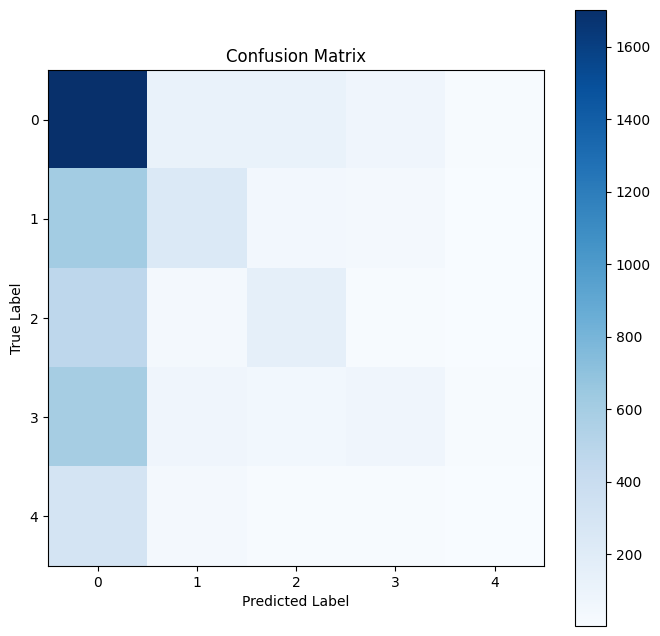

In [33]:
# Calculate class weights
class_weights = compute_class_weight('balanced',  classes=np.unique(y_train), y=y_train, majority_class_weight_factor=2.5)
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), )
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_train])



train_data = lgb.Dataset(X_train, label=y_train,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_train) == 0:
    raise ValueError("X_train cannot be empty")



# Define hyperparameters and objective for LightGBM
params = {
    'objective': 'multiclass',  # Adjust for your specific task
    'num_class': len(np.unique(y_train)),# Number of classes in your dataset
    'metric': 'multi_logloss',
    'learning_rate':  0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'boosting_type': 'gbdt',
    'verbose': -1
    # ... other hyperparameters
}
print(type(train_data))
num_round=100
model = lgb.train(params,
                 train_data,
                 num_round,
                 valid_sets=[train_data,test_data],
                 callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred.shape)
y_pred_classes = y_pred.argmax(axis=1)
print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**NOSE TRAINING AND TEST VALIDATION**

In [34]:
#Initialize the dataset
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/nose/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_dataset/nose/test")

# Extract features for all images in one line
X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels
X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels


<class 'lightgbm.basic.Dataset'>
Training until validation scores don't improve for 20 rounds
[20]	training's multi_logloss: 1.37793	valid_1's multi_logloss: 1.39791
[40]	training's multi_logloss: 1.31999	valid_1's multi_logloss: 1.38343
[60]	training's multi_logloss: 1.28214	valid_1's multi_logloss: 1.37859
[80]	training's multi_logloss: 1.25247	valid_1's multi_logloss: 1.37763
[100]	training's multi_logloss: 1.22492	valid_1's multi_logloss: 1.37728
Did not meet early stopping. Best iteration is:
[99]	training's multi_logloss: 1.22637	valid_1's multi_logloss: 1.37723
(4776, 5)
(4776,)
              precision    recall  f1-score   support

           0       0.45      0.84      0.59      2018
           1       0.34      0.08      0.13       927
           2       0.45      0.21      0.29       670
           3       0.36      0.17      0.23       802
           4       0.17      0.04      0.07       359

    accuracy                           0.43      4776
   macro avg       0.35    

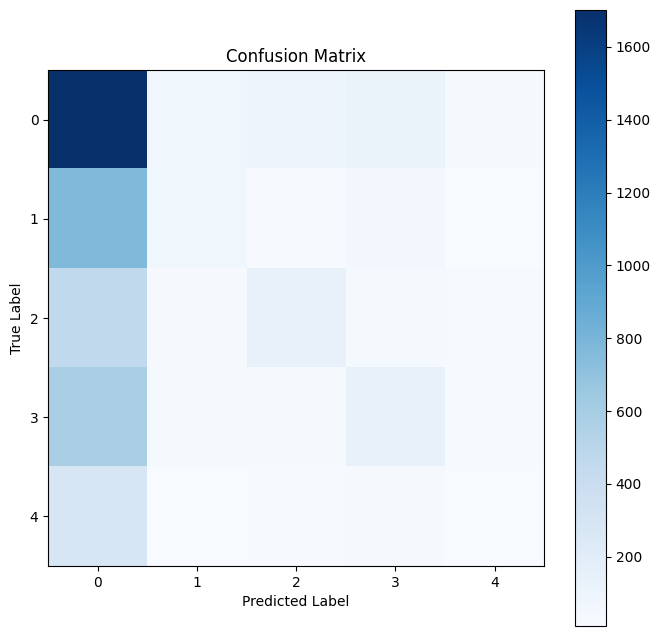

In [35]:
# Calculate class weights
class_weights = compute_class_weight('balanced',  classes=np.unique(y_train), y=y_train, majority_class_weight_factor=2.5)
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), )
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_train])



train_data = lgb.Dataset(X_train, label=y_train,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_train) == 0:
    raise ValueError("X_train cannot be empty")



# Define hyperparameters and objective for LightGBM
params = {
    'objective': 'multiclass',  # Adjust for your specific task
    'num_class': len(np.unique(y_train)),# Number of classes in your dataset
    'metric': 'multi_logloss',
    'learning_rate':  0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'boosting_type': 'gbdt',
    'verbose': -1
    # ... other hyperparameters
}
print(type(train_data))
num_round=100
model = lgb.train(params,
                 train_data,
                 num_round,
                 valid_sets=[train_data,test_data],
                 callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred.shape)
y_pred_classes = y_pred.argmax(axis=1)
print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
